# Sign Language Dataset

The Sign Language Dataset consists of 9680 grayscale images of hand signs for the digits 0-9 and the alphabets a-z. Thus, this is a multiclass classification problem with 36 classes. Your task is to build a machine learning model that can accurately classify images from this dataset.

## Loading the dataset

You **do not** need to upload any data. Both the visible training dataset and the hidden test dataset are already available on the Jupyter hub.

In [2]:
import os
import csv
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Setting the path of the training dataset (that was already provided to you)

running_local = True if os.getenv('JUPYTERHUB_USER') is None else False
DATASET_PATH = "."

# Set the location of the dataset
if running_local:
    # If running on your local machine, the sign_lang_train folder's path should be specified here
    local_path = "./data/images_manipulated"
    if os.path.exists(local_path):
        DATASET_PATH = local_path
else:
    # If running on the Jupyter hub, this data folder is already available
    # You DO NOT need to upload the data!
    DATASET_PATH = "/data/mlproject22/sign_lang_train"

In [7]:
# Utility function

def read_csv(csv_file):
    with open(csv_file, newline='') as f:
        reader = csv.reader(f)
        data = list(reader)
    return data

## Data Loading using PyTorch

For creating and training your model, you can work with any machine learning library of your choice. 

If you choose to work with [PyTorch](https://pytorch.org/), you will need to create your own [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class for loading the data. This is provided below. See [here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) for a nice example of how to create a custom data loading pipeline in PyTorch. 

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils, io
from torchvision.utils import make_grid
from PIL import Image

from string import ascii_lowercase

class SignLangDataset(Dataset):
    """Sign language dataset"""

    def __init__(self, csv_file, root_dir, transform=transforms.Compose([transforms.Resize((128, 128)),transforms.ToTensor(),])):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = read_csv(os.path.join(root_dir,csv_file))
        self.root_dir = root_dir
        self.transform = transform
        # List of class names in order
        self.class_names = list(map(str, list(range(10)))) + list(ascii_lowercase)

    def __len__(self):
        """
        Calculates the length of the dataset-
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns one sample (dict consisting of an image and its label)
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Read the image and labels
        image_path = os.path.join(self.root_dir, self.data[idx][1])
        
        # Read image as a grayscale PIL image
        image = Image.open(image_path).convert("L")  # 'L' = grayscale mode

        if self.transform:
            image = self.transform(image)

        # The label is the index of the class name in the list ['0','1',...,'9','a','b',...'z']
        # because we should have integer labels in the range 0-35 (for 36 classes)
        label = self.class_names.index(self.data[idx][0])
        
        sample = {'image': image, 'label': label}

        return sample
    
    def show_sample(self, idx: int) -> None:
        """
        Displays a grayscale image with its corresponding class label (0-35).
        
        Args:
            image (numpy.ndarray): The image to display. Shape should be (1, H, W) or (H, W).
            label (int): Integer label in range 0-35.
        """

        sample = self[idx]
        image = sample["image"]
        label_index = sample["label"]
        label = self.class_names[label_index]

        # Flatten channel dimension if needed
        if image.ndim == 3 and image.shape[0] == 1:
            image = image[0] 
        
        plt.imshow(image, cmap="gray")
        plt.title(f"Label: {label}")
        plt.axis("off")
        plt.show()

# Define label mapping
class_names = list(map(str, range(10))) + list(ascii_lowercase)

# Transform Images to 128x128
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

sign_dataset = SignLangDataset("labels_manipulated.csv", DATASET_PATH, transform)
print(len(sign_dataset))

18056


In [ ]:
class DuplicatedAugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, augment_fn, duplicate_factor=2):
        """
        Args:
            base_dataset: Original dataset (e.g. SignLangDataset)
            augment_fn: A torchvision transform to apply to duplicates
            duplicate_factor: How many times to duplicate each original sample
        """
        self.base_dataset = base_dataset
        self.augment_fn = augment_fn
        self.duplicate_factor = duplicate_factor

    def __len__(self):
        return len(self.base_dataset) * self.duplicate_factor

    def __getitem__(self, idx):
        base_idx = idx % len(self.base_dataset)
        original_sample = self.base_dataset[base_idx]

        if idx // len(self.base_dataset) > 0:
            augmented_image = self.augment_fn(transforms.ToPILImage()(original_sample['image']))
            image = transforms.ToTensor()(augmented_image)
        else:
            image = original_sample['image']

        return {'image': image, 'label': original_sample['label']}

### Test Train Data Split


In [ ]:
val_size = int(0.2 * len(sign_dataset))
train_size = len(sign_dataset) - val_size

generator = torch.Generator().manual_seed(47) # for reproducability
train_dataset, val_dataset = random_split(sign_dataset, [train_size, val_size], generator=generator)

augmentation = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
])

augmented_dataset = DuplicatedAugmentedDataset(
    base_dataset=train_dataset,
    augment_fn=augmentation,
    duplicate_factor=2
)

train_loader = DataLoader(augmented_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print(f"Train dataset: {len(augmented_dataset)}")
print(f"Validation dataset: {len(val_dataset)}")

Train dataset: 28890
Validation dataset: 3611


### CNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SignLangCNN(nn.Module):
    def __init__(self, 
                 num_classes=36, 
                 dropout_rate=0.3, 
                 conv_channels=[32, 64, 128],
                 linear_size=256,
                 activation="relu",
                 kernel_size=3):
        """
        Args:
            num_classes (int): Number of output classes.
            dropout_rate (float): Dropout rate for regularization.
            conv_channels (list): List of output channels for each Conv layer.
        """
        super(SignLangCNN, self).__init__()
        self.activation = activation

        assert len(conv_channels) == 3, "conv_channels must contain exactly 3 values"

        c1, c2, c3 = conv_channels

        self.conv1 = nn.Conv2d(1, c1, kernel_size=kernel_size, padding=kernel_size // 2)   # [B, c1, 128, 128]
        self.pool1 = nn.MaxPool2d(2, 2)                           # [B, c1, 64, 64]

        self.conv2 = nn.Conv2d(c1, c2, kernel_size=kernel_size, padding=kernel_size // 2)  # [B, c2, 64, 64]
        self.pool2 = nn.MaxPool2d(2, 2)                           # [B, c2, 32, 32]

        self.conv3 = nn.Conv2d(c2, c3, kernel_size=kernel_size, padding=kernel_size // 2)  # [B, c3, 32, 32]
        self.pool3 = nn.MaxPool2d(2, 2)                           # [B, c3, 16, 16]

        self.flattened_size = c3 * 16 * 16
        self.fc1 = nn.Linear(self.flattened_size, linear_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(linear_size, num_classes)

    def forward(self, x):
        activation = None
        if (self.activation == "relu"):
            activation = F.relu
        elif (self.activation == "sigmoid"):
            activation = F.sigmoid
        else:
            raise ValueError(f"Unsupported activation function: {self.activation}")
        x = self.pool1(activation(self.conv1(x)))  # [B, c1, 64, 64]
        x = self.pool2(activation(self.conv2(x)))  # [B, c2, 32, 32]
        x = self.pool3(activation(self.conv3(x)))  # [B, c3, 16, 16]
        x = x.view(x.size(0), -1)             
        x = self.dropout(activation(self.fc1(x)))
        x = self.fc2(x)                        
        return x

### Train Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA available:", torch.cuda.is_available())
print("Device being used:", device)
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

model = SignLangCNN(36, 0.2062, [32, 64, 128], activation="relu", kernel_size=5, linear_size=382)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00021806877744184937)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

CUDA available: True
Device being used: cuda
GPU name: NVIDIA GeForce GTX 1060 6GB


### Evaluation

In [196]:
def evaluate_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    return correct / total

val_acc = evaluate_accuracy(model, val_loader, device)
print(f"Validation Accuracy: {val_acc:.2%}")

Validation Accuracy: 98.78%


In [197]:
val_acc = evaluate_accuracy(model, train_loader, device)
print(f"Training Accuracy: {val_acc:.2%}")

Training Accuracy: 99.35%


In [184]:
torch.save(model.state_dict(), "sign_lang_model_98a_32_64_128_382l_60epoch.pt")

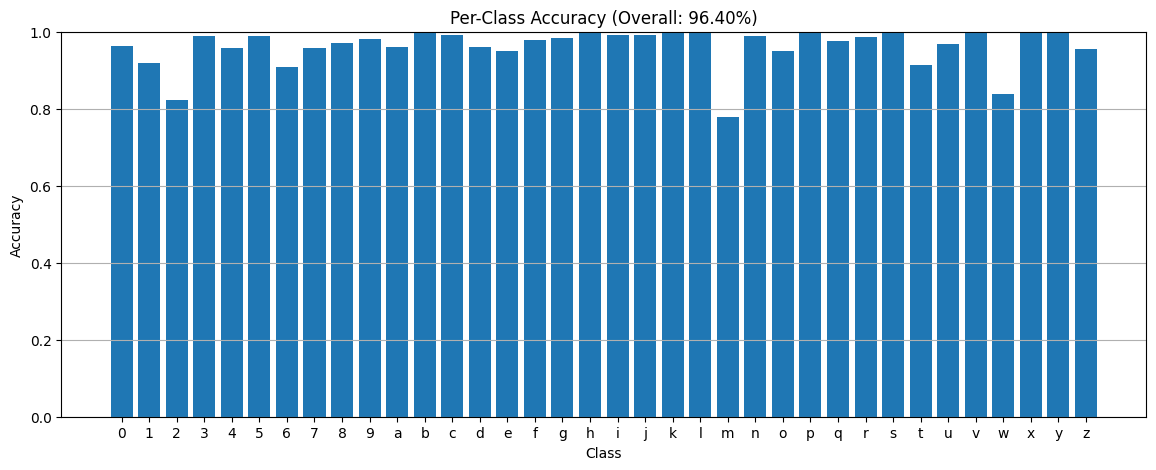

In [ ]:
def plot_per_class_accuracy(model, dataloader, device, num_classes=36, class_names=None):
    """
    Evaluates and plots per-class accuracy for a classification model.

    Also shows the overall accuracy in the plot title.
    """
    if class_names is None:
        class_names = list(map(str, range(10))) + list(ascii_lowercase)

    model.eval()
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

            for label, pred in zip(labels, preds):
                class_total[label] += 1
                if label == pred:
                    class_correct[label] += 1

    per_class_accuracy = [correct / total if total != 0 else 0.0
                          for correct, total in zip(class_correct, class_total)]
    overall_accuracy = total_correct / total_samples

    plt.figure(figsize=(14, 5))
    plt.bar(class_names, per_class_accuracy)
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.title(f"Per-Class Accuracy (Overall: {overall_accuracy:.2%})")
    plt.ylim(0, 1.0)
    plt.grid(axis='y')
    plt.show()
    
plot_per_class_accuracy(model, val_loader, device, 36, sign_dataset.class_names)



#### Confusion Matrix

In [38]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd
import seaborn as sns

y_true = []
y_pred = []


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SignLangCNN(36, 0.2062, [32, 64, 128], activation="relu", kernel_size=5, linear_size=382)
model.load_state_dict(torch.load("sign_lang_model_98a_32_64_128_382l_60epoch.pt", map_location=torch.device('cpu')))
model.eval()

with torch.no_grad():
    for batch in val_loader:  # or test_loader
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())



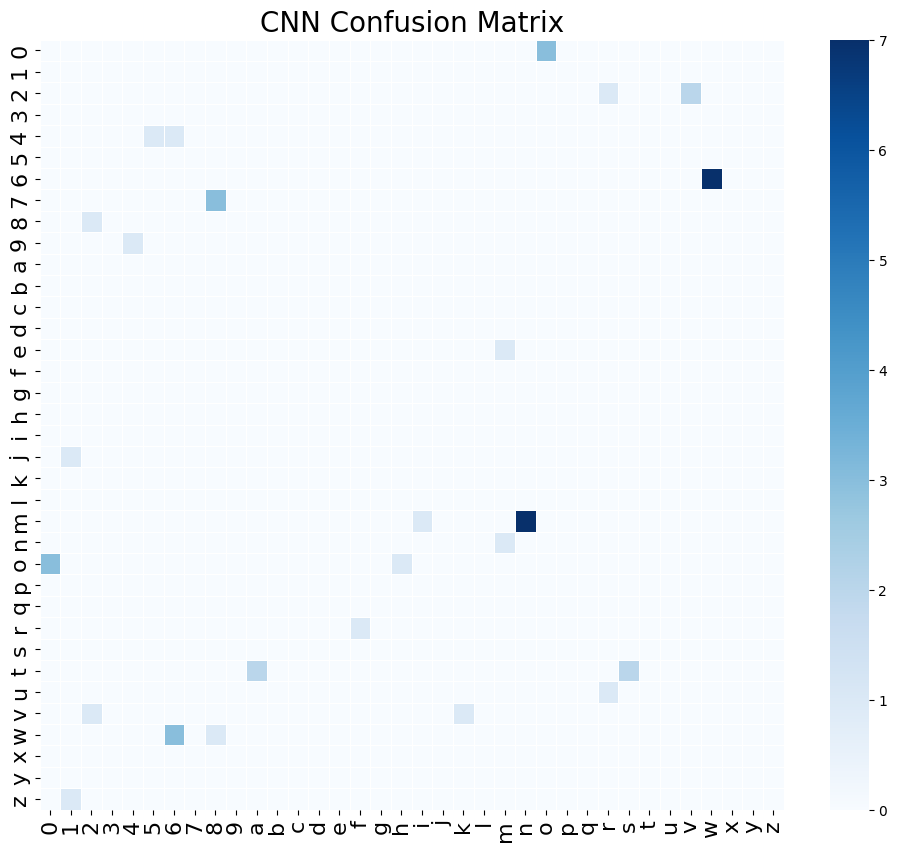

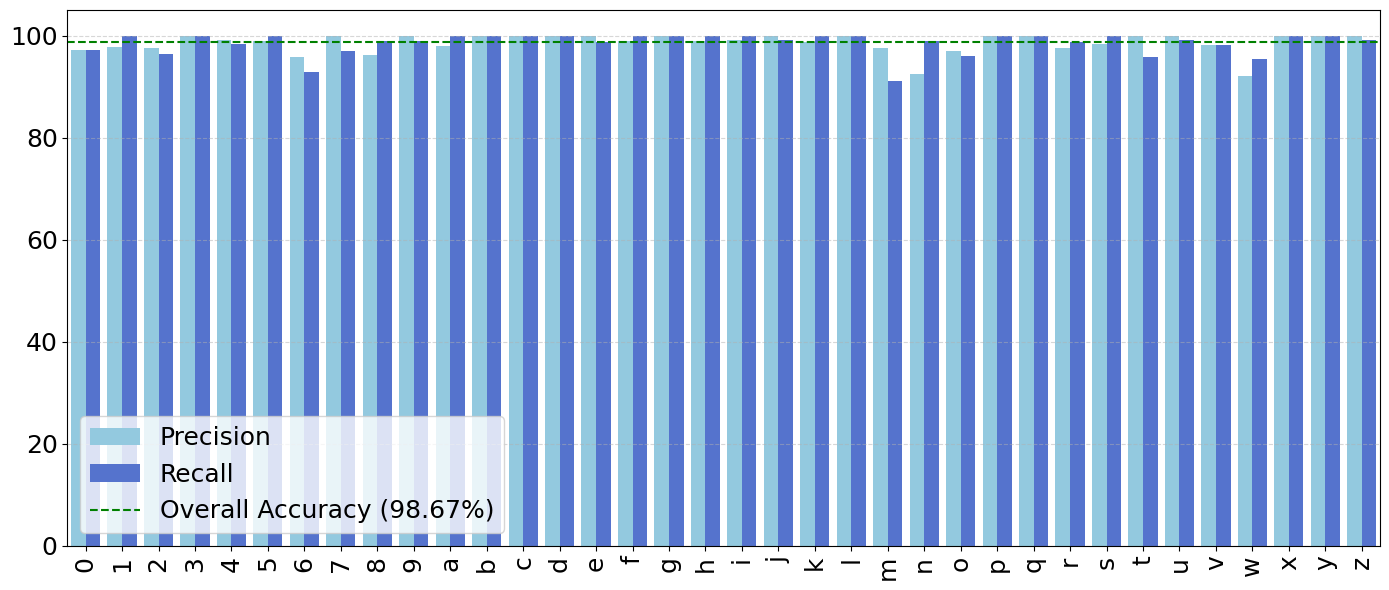

In [ ]:
cm = confusion_matrix(y_true, y_pred, labels=list(range(36)))

def plot_confusion_matrix(y_true, y_pred, class_names, caption="Confusion Matrix (without diagonal)"):
    """
    Plots a confusion matrix using matplotlib.
    
    Args:
        y_true (list or array): Ground truth labels.
        y_pred (list or array): Predicted labels.
    """
    cm = confusion_matrix(y_true, y_pred)
    np.fill_diagonal(cm, 0)  # Zero out diagonal to highlight errors

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names,
                annot=False, cmap="Blues", linewidths=0.5)
    
    plt.title(caption, fontsize=20)
    plt.xlabel("", fontsize=16)
    plt.ylabel("", fontsize=16)
    plt.xticks(fontsize=16, rotation=90)
    plt.yticks(fontsize=16)


CLASS_NAMES = list(map(str, range(10))) + list(ascii_lowercase)
plot_confusion_matrix(y_true, y_pred, CLASS_NAMES, "CNN Confusion Matrix")

report_dict = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
overall_accuracy = accuracy_score(y_true, y_pred)

data = {
    'Class': CLASS_NAMES,
    'Precision': [report_dict[label]['precision'] * 100 for label in CLASS_NAMES],
    'Recall': [report_dict[label]['recall'] * 100 for label in CLASS_NAMES]
}

df = pd.DataFrame(data)
df_melted = df.melt(id_vars='Class', var_name='Metric', value_name='Score')

plt.figure(figsize=(14, 6))
sns.barplot(data=df_melted, x='Class', y='Score', hue='Metric', palette=['skyblue', 'royalblue'])

plt.axhline(overall_accuracy * 100, color='green', linestyle='--', label=f'Overall Accuracy ({overall_accuracy:.2%})')

plt.xlabel('', fontsize=18)
plt.ylabel('', fontsize=18)
plt.ylim(0, 105)
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### K-Fold Cross Validation

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset

def k_fold_cross_validation(k_folds, dataset, model_fn, device, epochs):
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    results = {}
    
    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
        print(f"\n Fold {fold + 1}/{k_folds}")

        model = model_fn().to(device)
        
        augmentation = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.RandomRotation(15),
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
        ])
        train_subset = DuplicatedAugmentedDataset(
            base_dataset=Subset(dataset, train_ids),
            augment_fn=augmentation,
            duplicate_factor=2
        )
        val_subset = Subset(dataset, val_ids)
        
        train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.00021806877744184937)

        for epoch in range(epochs):
            model.train()
            for batch in train_loader:
                images = batch['image'].to(device)
                labels = batch['label'].to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            val_acc = evaluate_accuracy(model, val_loader, device)
            print(f" - Fold {fold + 1} Current Validation Accuracy: {val_acc:.2%}")

        train_acc = evaluate_accuracy(model, train_loader, device)
        print(f"Fold {fold + 1} Train Accuracy: {train_acc:.2%}")

        val_acc = evaluate_accuracy(model, val_loader, device)
        print(f"Fold {fold + 1} Validation Accuracy: {val_acc:.2%}")
        results[fold] = val_acc
        torch.save(model, f"cv_{fold}")

    average_acc = sum(results.values()) / k_folds
    print(f"Average Accuracy: {average_acc:.2%}")
    return average_acc

k_fold_cross_validation(5, sign_dataset, lambda: SignLangCNN(36, 0.2062, [32, 64, 128], activation="relu", kernel_size=5, linear_size=382), device, epochs=60)


🔁 Fold 1/5
✅ Fold 1 Accuracy: 98.42%

🔁 Fold 2/5
✅ Fold 2 Accuracy: 98.37%

🔁 Fold 3/5
✅ Fold 3 Accuracy: 98.37%

🔁 Fold 4/5
✅ Fold 4 Accuracy: 97.90%

🔁 Fold 5/5
✅ Fold 5 Accuracy: 98.03%
✅ Average Accuracy: 98.22%


0.982166479132146

In [178]:
torch.save(SignLangCNN(36, 0.2062, [32, 64, 128], activation="relu", kernel_size=5, linear_size=382), "test.pt")

### Hyperparemeter Tuning

#### Grid Search

In [ ]:
import random
import copy

def random_search_cnn(train_dataset, val_dataset, param_space, device, n_iter=80, epochs=40):
    """
    Performs a random search over the CNN hyperparameters.

    Args:
        train_dataset: torch.utils.data.Dataset
        val_dataset: torch.utils.data.Dataset
        param_space: Dictionary defining search space (can include ranges or lists)
        device: "cuda" or "cpu"
        n_iter: Number of random samples to try
        epochs: Number of training epochs

    Returns:
        List of (hyperparams, accuracy) tuples sorted by accuracy
    """
    results = []

    for _ in range(n_iter):
        params = {
            'lr': float(np.exp(np.random.uniform(np.log(param_space['lr'][0]), np.log(param_space['lr'][1])))),
            'batch_size': random.choice(param_space['batch_size']),
            'dropout': random.uniform(*param_space['dropout']),
            'conv_channels': random.choice(param_space['conv_channels']),
            'linear_size': random.choice(param_space['linear_size']),
            'activation': random.choice(param_space['activation']),
            'kernel_size': random.choice(param_space['kernel_size']),
            'epochs': epochs  # Fixed
        }

        print(f"\n Testing combination: {params}")

        model = SignLangCNN(
            num_classes=36,
            dropout_rate=params['dropout'],
            conv_channels=params['conv_channels'],
            linear_size=params['linear_size'],
            activation=params['activation'],
            kernel_size=params['kernel_size']
        ).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
        
        train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

        best_val_loss = float('inf')
        patience = 5
        wait = 0
        min_delta = 0.01
        best_model_state = None

        for epoch in range(epochs):
            model.train()

            train_loss = 0
            correct = 0
            total = 0

            for batch in train_loader:
                images = batch['image'].to(device)
                labels = batch['label'].to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                batch_size = labels.size(0)
                train_loss += loss.item() * batch_size
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += batch_size

            epoch_loss = train_loss / total
            epoch_acc = correct / total
            print(f"Epoch {epoch+1}/{epochs} — Train Loss: {epoch_loss:.4f} — Train Acc: {epoch_acc:.2%}")

            # ----- Validation -----
            model.eval()
            val_loss = 0
            val_total = 0
            with torch.no_grad():
                for batch in val_loader:
                    images = batch['image'].to(device)
                    labels = batch['label'].to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * labels.size(0)
                    val_total += labels.size(0)
            val_loss /= val_total
            print(f"           → Val Loss: {val_loss:.4f}")

            # ----- Early Stopping Logic -----
            if best_val_loss - val_loss > min_delta:
                best_val_loss = val_loss
                best_model_state = copy.deepcopy(model.state_dict())
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
            
            if epoch_acc < 0.4 and epoch >= 10:
                print("Early stop: model is not learning well. Accuracy <40%% at epoch 10")
                break

        if best_model_state:
            model.load_state_dict(best_model_state)

        acc = evaluate_accuracy(model, val_loader, device)
        print(f"Accuracy: {acc:.2%}")
        results.append((copy.deepcopy(params), acc))

    results.sort(key=lambda x: x[1], reverse=True)
    return results

param_space = {
    'lr': (1e-4, 1e-2),  
    'batch_size': [8, 16, 32, 64, 128],  
    'dropout': (0.2, 0.5),  
    'conv_channels': [
        [16, 32, 64],
        [32, 64, 128],
        [48, 96, 192]
    ],
    'linear_size': [128, 192, 256, 384],
    'activation': ["relu", "sigmoid"],
    'kernel_size': [3, 5],
}

results = random_search_cnn(augmented_dataset, val_dataset, param_space, device)

# Show top results
for i, (params, acc) in enumerate(results):
    print(f"{i+1}. {params} => Accuracy: {acc:.2%}")


🔍 Testing combination: {'lr': 0.000463246648991257, 'batch_size': 32, 'dropout': 0.45530686154029965, 'conv_channels': [32, 64, 128], 'linear_size': 256, 'activation': 'sigmoid', 'kernel_size': 5, 'epochs': 40}
Epoch 1/40 — Train Loss: 3.6352 — Train Acc: 2.96%
           → Val Loss: 3.5909
Epoch 2/40 — Train Loss: 3.6211 — Train Acc: 2.84%
           → Val Loss: 3.5885
Epoch 3/40 — Train Loss: 3.6107 — Train Acc: 3.04%
           → Val Loss: 3.5934
Epoch 4/40 — Train Loss: 3.6053 — Train Acc: 3.10%
           → Val Loss: 3.5817
Epoch 5/40 — Train Loss: 3.6023 — Train Acc: 2.86%
           → Val Loss: 3.5878
Epoch 6/40 — Train Loss: 3.6013 — Train Acc: 2.93%
           → Val Loss: 3.5880
⏹️ Early stopping at epoch 6
✅ Accuracy: 2.96%

🔍 Testing combination: {'lr': 0.0002400641350354702, 'batch_size': 64, 'dropout': 0.36043523654320486, 'conv_channels': [48, 96, 192], 'linear_size': 256, 'activation': 'relu', 'kernel_size': 5, 'epochs': 40}
Epoch 1/40 — Train Loss: 2.1815 — Train Acc: 

KeyboardInterrupt: 

## Prediction Stub

You will need to provide a function that can be used to make predictions using your final trained model. 

**IMPORTANT**

1. The name of your prediction function must be `leader_board_predict_fn`
2. Your prediction function should be able take as input a 4-D numpy array of shape [batch_size,1,128,128] and produce predictions in the form of a 1-D numpy array of shape [batch_size,]. 
3. Predictions for each image should be an integer in the range 0-35, that is `0` for the digit $0$, `1` for the digit $1$, .... , `9` for the digit $9$, `10` for the letter $a$, `11` for the letter $b$, ..., `35` for the letter $z$.
4. Your prediction function should internally load your trained model and take care of any data transformations that you need.

Below we provide an implementation of the `leader_board_predict_fn` function, in which we show how a trained model can be loaded (from the weights saved on the disk) for making predictions. This example is for PyTorch, but you are free to use any framework of your choice for your model. The only requirement is that this function should accept a numpy array (with the proper shape) as the input and should produce a numpy array (with the proper shape) as the output. What you do internally is up to you.

Note that the model that we load here is not properly trained and so its performance is very bad. This example is only for showing you how a model can be loaded in PyTorch and how predictions can be made.

In [ ]:
def leader_board_predict_fn(input_batch):
    """
    Function for making predictions using your trained model.
    
    Args:
        input_batch (numpy array): Input images (4D array of shape 
                                   [batch_size, 1, 128, 128])
        
    Returns:
        output (numpy array): Predictions of the your trained model 
                             (1D array of int (0-35) of shape [batch_size, ])
    """
    prediction = None
    
    batch_size, channels, height, width = input_batch.shape
    
    import torch.nn as nn
    import torch.nn.functional as F

    class SignLangCNN(nn.Module):
        def __init__(self, 
                     num_classes=36, 
                     dropout_rate=0.3, 
                     conv_channels=[32, 64, 128],
                     linear_size=256,
                     activation="relu",
                     kernel_size=3):
            """
            Args:
                num_classes (int): Number of output classes.
                dropout_rate (float): Dropout rate for regularization.
                conv_channels (list): List of output channels for each Conv layer.
            """
            super(SignLangCNN, self).__init__()
            self.activation = activation

            assert len(conv_channels) == 3, "conv_channels must contain exactly 3 values"

            c1, c2, c3 = conv_channels

            self.conv1 = nn.Conv2d(1, c1, kernel_size=kernel_size, padding=kernel_size // 2)   # [B, c1, 128, 128]
            self.pool1 = nn.MaxPool2d(2, 2)                           # [B, c1, 64, 64]

            self.conv2 = nn.Conv2d(c1, c2, kernel_size=kernel_size, padding=kernel_size // 2)  # [B, c2, 64, 64]
            self.pool2 = nn.MaxPool2d(2, 2)                           # [B, c2, 32, 32]

            self.conv3 = nn.Conv2d(c2, c3, kernel_size=kernel_size, padding=kernel_size // 2)  # [B, c3, 32, 32]
            self.pool3 = nn.MaxPool2d(2, 2)                           # [B, c3, 16, 16]

            self.flattened_size = c3 * 16 * 16
            self.fc1 = nn.Linear(self.flattened_size, linear_size)
            self.dropout = nn.Dropout(dropout_rate)
            self.fc2 = nn.Linear(linear_size, num_classes)

        def forward(self, x):
            activation = None
            if (self.activation == "relu"):
                activation = F.relu
            elif (self.activation == "sigmoid"):
                activation = F.sigmoid
            else:
                raise ValueError(f"Unsupported activation function: {self.activation}")
            x = self.pool1(activation(self.conv1(x)))  # [B, c1, 64, 64]
            x = self.pool2(activation(self.conv2(x)))  # [B, c2, 32, 32]
            x = self.pool3(activation(self.conv3(x)))  # [B, c3, 16, 16]
            x = x.view(x.size(0), -1)             
            x = self.dropout(activation(self.fc1(x)))
            x = self.fc2(x)                       
            return x
    
    model = SignLangCNN(36, 0.2062, [32, 64, 128], activation="relu", kernel_size=5, linear_size=382)
    model.load_state_dict(torch.load("sign_lang_model_full_dataset_32_64_128_382l_60epoch.pt", map_location=torch.device('cpu')))
    model.eval()

    input_batch = torch.from_numpy(input_batch).float()

    logits = model(input_batch)

    prediction = torch.argmax(logits, dim=1).numpy()


    assert prediction is not None, "Prediction cannot be None"
    assert isinstance(prediction, np.ndarray), "Prediction must be a numpy array"

    return prediction

## Evaluation

Your final model will be evaluated on a hidden test set containing images similar to the dataset that you are provided with.

For evaluating the performance of your model, we will use the normalized [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) metric from sklearn. This is simply the percentage of correct predictions that your model makes for all the images of the hidden test set. Hence, if all the predictions are correct, the score is 1.0 and if all predictions are incorrect, the score is 0.0. We will use the sklearn metric so that the accuracy function is agnostic to the machine learning framework you use.

In [23]:
from sklearn.metrics import accuracy_score
  
def accuracy(dataset_path, max_batches=30):
    """
    Calculates the average prediction accuracy.
    
    IMPORTANT
    =========
    In this function, we use PyTorch only for loading the data. When your `leader_board_predict_fn`
    function is called, we pass the arguments to it as numpy arrays. The output of `leader_board_predict_fn`
    is also expected to be a numpy array. So, as long as your `leader_board_predict_fn` function takes
    numpy arrays as input and produces numpy arrays as output (with the proper shapes), it does not
    matter what framework you used for training your network or for producing your predictions.
    
    Args:
        dataset_path (str): Path of the dataset directory
        
    Returns:
        accuracy (float): Average accuracy score over all images (float in the range 0.0-1.0)
    """

    # Create a Dataset object
    sign_lang_dataset = SignLangDataset(csv_file="labels.csv", root_dir=dataset_path)

    # Create a Dataloader
    sign_lang_dataloader = DataLoader(sign_lang_dataset, 
                                      batch_size=64,
                                      shuffle=True, 
                                      drop_last=True,
                                      num_workers=0)
    
    # Calculate accuracy for each batch
    accuracies = list()
    for batch_idx, sample in enumerate(sign_lang_dataloader):
        x = sample["image"].numpy()
        y = sample["label"].numpy()
        prediction = leader_board_predict_fn(x)
        accuracies.append(accuracy_score(y, prediction, normalize=True))
        
        # We will consider only the first 30 batches
        if batch_idx == (max_batches - 1):
            break

    assert len(accuracies) == max_batches
    
    # Return the average accuracy
    mean_accuracy = np.mean(accuracies)
    return mean_accuracy

We will now use your `leader_board_predict_fn` function for calculating the accuracy of your model. We provide the code for testing your loaded model on the visible training data. We will also evaluate your model's performance on the test dataset (the test dataset should only be used for evaluation and is **NOT** to be used for training your model).

In [26]:
DATASET_PATH="./data/images"

def get_score():
    """
    Function to compute scores for train and test datasets.
    """
    import torch
    import numpy as np
    from sklearn.metrics import accuracy_score
    import os
    import pwd
    import time
    import pathlib
    import pandas as pd
    import datetime
    
    ### LEADER BOARD TEST
    seed = 200

    torch.manual_seed(seed)
    np.random.seed(seed)

    # Calculate the accuracy on the training dataset
    # to check that your `leader_board_predict_fn` function 
    # works without any error
    dataset_score = accuracy(dataset_path=DATASET_PATH)

    assert isinstance(dataset_score, float), f"type of dataset_score is {type(dataset_score)}, but it must be float"
    assert 0.0<=dataset_score<=1.0, f"Value of dataset_score is {dataset_score}, but it must be between 0.0 and 1.0"

    # This is your accuracy score on the visible training dataset
    # This is NOT used for the leaderboard.
    print(f"Accuracy score on training data: {dataset_score}")

    # There is a hidden test that will evaluate your trained model on the hidden test set
    # This hidden dataset and the accuracy for this will not be visible to you when you
    # validate this notebook. The accuracy score on the hidden dataset will be used
    # for calculating your leaderboard score.

    seed = 200

    torch.manual_seed(seed)
    np.random.seed(seed)

    user_id = pwd.getpwuid( os.getuid() ).pw_name
    curtime = time.time()
    dt_now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

    try:  # 
        HIDDEN_DATASET_PATH = os.path.expanduser("/data/mlproject22-test-data/sign_lang_test")
        hiddendataset_score = accuracy(dataset_path=HIDDEN_DATASET_PATH)

        assert isinstance(hiddendataset_score, float), f"type of dataset_score is {type(dataset_score)}, but it must be float"
        assert 0.0<=hiddendataset_score<=1.0, f"Value of dataset_score is {dataset_score}, but it must be between 0.0 and 1.0"

        print(f"Leaderboard score: {hiddendataset_score}")

        score_dict = dict(
            score_hidden=hiddendataset_score,
            score_train=dataset_score,
            unixtime=curtime,
            user=user_id,
            dt=dt_now,
            comment="",
        )

    except Exception as e:
        err = str(e)
        score_dict = dict(
            score_hidden=float("nan"),
            score_train=dataset_score,
            unixtime=curtime,
            user=user_id,
            dt=dt_now,
            comment=err
        )


    #if list(pathlib.Path(os.getcwd()).parents)[0].name == 'source':
    #    print("we are in the source directory... replacing values.")
    #    print(pd.DataFrame([score_dict]))
    #    score_dict["score_hidden"] = -1
    #    score_dict["score_train"] = -1
    #    print("new values:")
    #    print(pd.DataFrame([score_dict]))

    pd.DataFrame([score_dict]).to_csv("sign_lang.csv", index=False)

    ### LEADER BOARD TEST
    
get_score()

Accuracy score on training data: 0.9994791666666667
